# Imports

In [16]:
import pandas as pd     
import numpy as np

import spacy
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm 
from itertools import product

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_score, f1_score, recall_score

# Functions

In [2]:
def metrics_model(list_estimators):
    results = []
    for n_est in list_estimators:
        model = RandomForestClassifier(n_estimators=n_est, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        ps = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        
        results.append([n_est, f1, ps, recall])
    return pd.DataFrame(results, columns=['n_estimators', 'f1', 'precision', 'recall'])

In [44]:
def search_cross_valid(search_space, X_train, y_train, X_test, y_test, SEED=42):
    results, params = [], [],

    for n_est, crt, max_f in tqdm(search_space, desc="Treinamento: "):
        model = RandomForestClassifier(n_estimators=n_est, criterion=crt, max_features=max_f, random_state=SEED)

        cv = StratifiedKFold(n_splits=10, random_state=SEED, shuffle=True)

        steps = [('model', model)]
        pipeline = Pipeline(steps=steps)

        scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        ps = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        r = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        
        print('Mean f1: %.3f' % np.mean(scores))
        
        print('F1-score test: %.3f' % f1)
        print('Precision score: %.3f' % ps)
        print('Recall test: %.3f' % r)

        parm = dict(n_estimators=n_est, criterion=crt, max_features=max_f)

        print("Parameters: ", parm)
        print("Score of validation: ", np.mean(scores))

#         f1_scores.append(f1)
#         precision_s.append(ps)
#         recall.append(r)
        params.append(parm)
        results.append([n_est, f1, ps, r])

    zipped_results = zip(f1_scores, precision_s, recall, params)
    best_result =  max(zipped_results, key = lambda res: res[1])
    best_f1_score, best_precision_s, best_recall, best_params = best_result

    print('------------------------------')
    print("Best parameters: ", best_params)
    print("Best f1-score score: ", best_f1_score)
    print("Best precision score: ", best_precision_s)
    print("Best recall score: ", best_recall)
    
    return best_params, pd.DataFrame(results, columns=['n_estimators', 'f1', 'precision', 'recall'])

In [3]:
import matplotlib.pyplot as plt

def plot_results(results):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(results['n_estimators'], results[['f1', 'precision', 'recall']])
    plt.xlabel("N_estimators")
    plt.ylabel('Results')
    plt.legend(['f1', 'precision', 'recall'])

# Loading the dataset

In [4]:
df = pd.read_csv("data/reviews_final.csv")

In [5]:
df.head()

,title,review,rating,date,label
0,Ótimo custo benefício.,Até agora estou amando o aparelho. Estou bem s...,5.0,25/10/2019,Good
1,Não recebi a versão global e produto veio sem ...,"Adquiri o produto em 09/11, chegou hoje e para...",1.0,14/11/2019,Bad
2,"Bom, bonito e barato. Porém sem nota fiscal!",Comprei o celular no sábado dia 26/10/19 e che...,5.0,31/10/2019,Good
3,"Bom, no prazo, carregador fora do padrão brasi...","Chegou dentro do prazo, bem embalado. Tudo ok,...",3.0,19/11/2019,Neutral
4,Celular acima das expectativas,O celular superou totalmente minhas expectativ...,5.0,29/10/2019,Good


In [6]:
df.dropna(inplace=True)

In [7]:
df['label'] = df['label'].replace('Neutral', 'Bad')

In [8]:
df['label'].value_counts()

Good    4448
Bad      320
Name: label, dtype: int64

In [9]:
df.shape

(4768, 5)

# Bag of words

In [10]:
nlp = spacy.load('pt_core_news_sm')

In [11]:
stopwords = nlp.Defaults.stop_words
len(stopwords)

416

In [12]:
vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords)

# Models

## Parameters

In [30]:
n_estimators = list(range(10, 50, 20))
criterions = ["gini", "entropy"]
max_features = ["sqrt"]

# criterions = ["gini", "entropy"]
# max_features = ["sqrt", "auto", "log2"]

In [31]:
search_space = tuple(product(n_estimators, criterions, max_features))

print("Amount of training sets that will be validate: ", len(search_space))

Amount of training sets that will be validate:  4


##  Model without stemming

### Splitting data into training and testing

In [26]:
X = vectorizer.fit_transform(df['review']).toarray()
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=42)

In [27]:
len(X[0])

6521

In [46]:
best_params, results = search_cross_valid(search_space, X_train, y_train, X_test, y_test)

Treinamento:  25%|█████████████████▊                                                     | 1/4 [00:10<00:30, 10.06s/it]

Mean f1: 0.942
F1-score test: 0.914
Precision score: 0.921
Recall test: 0.932
Parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9418703134271997


Treinamento:  50%|███████████████████████████████████▌                                   | 2/4 [00:15<00:14,  7.14s/it]

Mean f1: 0.945
F1-score test: 0.912
Precision score: 0.922
Recall test: 0.932
Parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9445649242056426


Treinamento:  75%|█████████████████████████████████████████████████████▎                 | 3/4 [00:36<00:13, 13.42s/it]

Mean f1: 0.944
F1-score test: 0.906
Precision score: 0.915
Recall test: 0.929
Parameters:  {'n_estimators': 30, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9436667206128284


Treinamento: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:48<00:00, 12.18s/it]

Mean f1: 0.944
F1-score test: 0.902
Precision score: 0.916
Recall test: 0.928
Parameters:  {'n_estimators': 30, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9436649224074373
------------------------------
Best parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'sqrt'}
Best f1-score score:  0.9122443068908349
Best precision score:  0.9223549639852603
Best recall score:  0.9322152341020266


In [47]:
results

,n_estimators,f1,precision,recall
0,10,0.913754,0.920717,0.932215
1,10,0.912244,0.922355,0.932215
2,30,0.905596,0.915034,0.928721
3,30,0.902352,0.916070,0.928022


In [15]:
results_no_stemmer = metrics_model(list(range(10, 100, 20)))

In [16]:
results_no_stemmer

,n_estimators,f1,precision,recall
0,10,0.913754,0.920717,0.932215
1,30,0.905596,0.915034,0.928721
2,50,0.906144,0.927070,0.930818
3,70,0.904723,0.925817,0.930119
4,90,0.904723,0.925817,0.930119


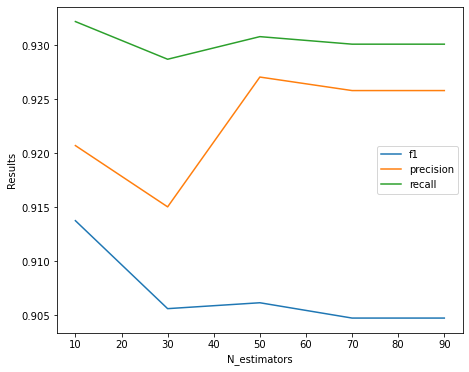

In [17]:
plot_results(results_no_stemmer)

In [18]:
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [19]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         Bad       0.88      0.13      0.22       111
        Good       0.93      1.00      0.96      1320

    accuracy                           0.93      1431
   macro avg       0.90      0.56      0.59      1431
weighted avg       0.93      0.93      0.91      1431



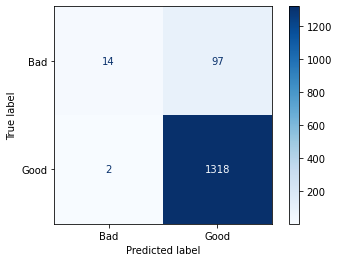

In [20]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', values_format='d')

# Stemming

In [21]:
reviews = df['review'].apply(lambda x: x.lower())
reviews_stemmer = []
stemmer = PorterStemmer()

for r in reviews:
    doc = nlp(r)
    sentences = doc.sents

    for sent in sentences:
        tokens = nlp(sent.text)

    # remove stop words and stemming
    review_processed = []
    
    for tkn in tokens:
        if tkn.is_punct == False and tkn.is_stop == False:
            review_processed.append(stemmer.stem(str(tkn)))

    review_text = " ".join(review_processed)
    reviews_stemmer.append(review_text)

In [22]:
reviews[0]

'até agora estou amando o aparelho. estou bem satisfeita, ainda mais com o ótimo custo benefício dele.comprei dia 16 e chegou dia 21, entrega extremamente rápida.'

In [23]:
reviews_stemmer[0]

'estou bem satisfeita , ainda mai com o ótimo custo benefício dele.comprei dia 16 e chegou dia 21 , entrega extremament rápida .'

# Model with stemming

## Splitting data into training and testing

In [24]:
X_s = vectorizer.fit_transform(reviews_stemmer).toarray()

X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=.3,
                                                    random_state=42)

In [25]:
len(X_s[0])

4074

In [26]:
results_stemmer = metrics_model(list(range(10, 100, 20)))

In [27]:
results_stemmer

,n_estimators,f1,precision,recall
0,10,0.905702,0.901908,0.923131
1,30,0.901856,0.902231,0.924528
2,50,0.900502,0.904252,0.925227
3,70,0.901894,0.906338,0.925926
4,90,0.900964,0.902071,0.924528


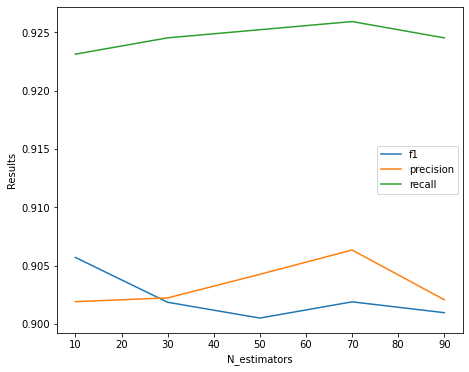

In [28]:
plot_results(results_stemmer)

In [29]:
model_stemmer = RandomForestClassifier(n_estimators=70, random_state=42)
model_stemmer.fit(X_train, y_train)

RandomForestClassifier(n_estimators=70, random_state=42)

In [30]:
print(classification_report(y_test, model_stemmer.predict(X_test)))

              precision    recall  f1-score   support

         Bad       0.62      0.12      0.20       111
        Good       0.93      0.99      0.96      1320

    accuracy                           0.93      1431
   macro avg       0.77      0.56      0.58      1431
weighted avg       0.91      0.93      0.90      1431



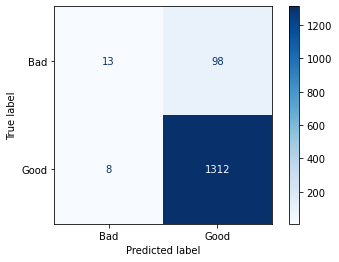

In [31]:
ConfusionMatrixDisplay.from_estimator(model_stemmer, X_test, y_test, cmap='Blues', values_format='d')